## Toxic Comments Clasification using 1D Convolutional Network and GloVe

Dataset link: <https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification>

The data contains toxic comments and corresponding labels

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
max_sequence_length = 100
max_vocab_size = 20000
embedding_dim = 100
validation_split = 0.2
batch_size = 128
epochs = 10
glove_path = "glove.6B/"

In [3]:
#loading glove

glove = dict()
with open(f'{glove_path}glove.6B.{embedding_dim}d.txt') as f:
    
    for line in f:
        val = line.split()
        glove[val[0]] = np.asarray(val[1:],dtype='float32')

print(f'Number of words in glove: {len(glove)}')

Number of words in glove: 400001


**Loading DataFrame**

In [4]:
train = pd.read_csv('data/jigsaw-toxic-comment-train.csv')

**Checking for null values**

In [5]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

**Splitting the data to text and labels**

In [6]:
labels = train.columns[2:].to_list()

In [7]:
targets = train[labels]
targets.head(3)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0


In [8]:
sentences = train["comment_text"]
sentences.head(3)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
Name: comment_text, dtype: object

**Plotting the sentence lengths**

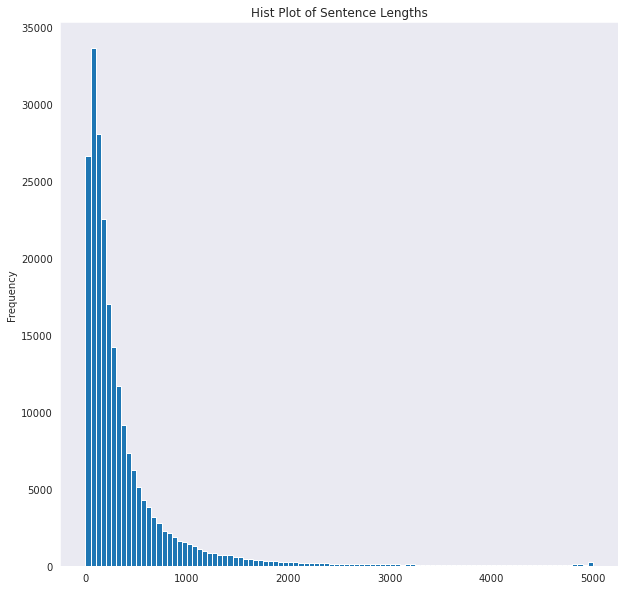

In [9]:
sns.set_style('dark')
length = sentences.apply(len)
plt.figure(figsize=(10,10))
length.plot(kind='hist',bins=100)
_=plt.title('Hist Plot of Sentence Lengths')

In [10]:
print("The maximum sequence length is:",length.max())
print("The mean sequence length is:",format(length.mean(),'.2f'))
print("The standard-deviation of sequence length is:",format(length.std(),".2f"))

The maximum sequence length is: 5000
The mean sequence length is: 391.01
The standard-deviation of sequence length is: 592.86


**Tokenizing the sentences and padding them**

In [11]:
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(sentences)

In [12]:
#print word index
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'are': 18,
 'have': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'an': 28,
 'wikipedia': 29,
 'my': 30,
 'from': 31,
 'by': 32,
 'at': 33,
 'do': 34,
 'about': 35,
 'so': 36,
 'me': 37,
 'what': 38,
 'can': 39,
 'there': 40,
 'talk': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'would': 45,
 'no': 46,
 'please': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'we': 56,
 'should': 57,
 'more': 58,
 'some': 59,
 "don't": 60,
 'other': 61,
 'who': 62,
 'see': 63,
 'here': 64,
 'think': 65,
 'also': 66,
 'his': 67,
 'know': 68,
 'because': 69,
 'how': 70,
 "i'm": 71,
 "it's": 72,
 'up': 73,
 'people': 74,
 'edit': 75,
 'only': 76,
 'why': 77,
 'out': 78,
 'am': 79,
 'when': 80,
 'use': 81,
 'a

In [13]:
sentences = tokenizer.texts_to_sequences(sentences)

In [14]:
data = pad_sequences(sentences,maxlen=max_sequence_length)
data

array([[   0,    0,    0, ..., 5460, 2456, 1094],
       [   0,    0,    0, ...,  606, 8919,  199],
       [   0,    0,    0, ...,    1,  733,  472],
       ...,
       [   0,    0,    0, ...,   14,   35, 9986],
       [   0,    0,    0, ...,  411,    5,  543],
       [   0,    0,    0, ...,    2, 1362,   11]], dtype=int32)

**Printing data shape**

In [15]:
print("Data Shape: ",data.shape)

Data Shape:  (223549, 100)


**Creating weights for embedding (the embedding matrix)**

In [16]:
print("Number of words: ",min(max_vocab_size,len(tokenizer.word_index)))

Number of words:  20000


In [17]:
embedding_matrix = np.zeros((max_vocab_size,embedding_dim))

for word,index in tokenizer.word_index.items():
    if(index < max_vocab_size):
        try:
            vec = glove[word]
            embedding_matrix[index] = vec
        except:
            pass
    else:
        break

**Creating the model**

In [18]:
#input
input_ = Input(shape=max_sequence_length)

In [19]:
#build embedding layer with exact same shape as embedding matrix - (maximum words / vocab size by embedding dimension)
x = Embedding(max_vocab_size,embedding_dim,weights=[embedding_matrix],input_length=max_sequence_length,trainable=False)(input_)

In [20]:
#let's use 128 filters and kernel_size 3
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128,activation='relu')(x)
output = Dense(len(labels),activation='sigmoid')(x)

In [21]:
model = Model(input_,output)

**Plotting the model**

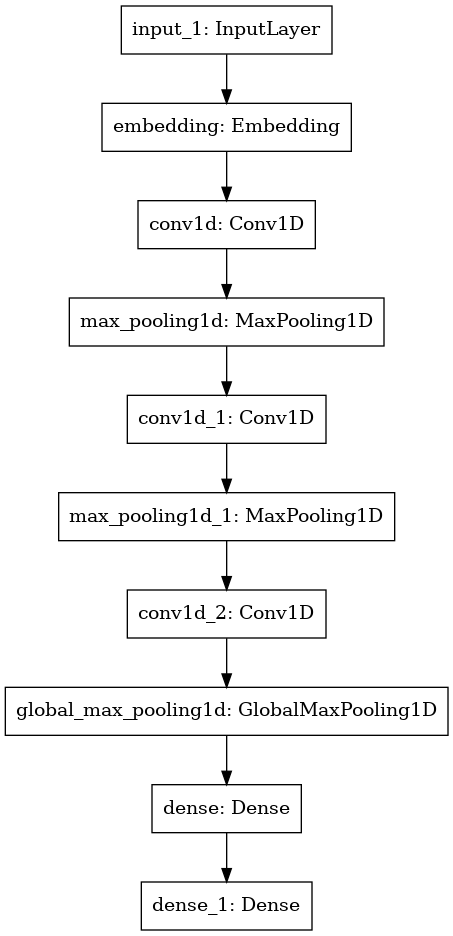

In [22]:
plot_model(model)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            49280 

**Compiling and fitting**

In [24]:
#compiling the model
model.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_call = EarlyStopping(patience=2)

In [27]:
#fit model
targets=targets.to_numpy()
history = model.fit(data,targets,batch_size = batch_size,epochs=epochs,validation_split=validation_split,callbacks=[early_call])

Epoch 1/10
1398/1398 [==============================] - 106s 74ms/step - loss: 0.0830 - accuracy: 0.9799 - val_loss: 0.0852 - val_accuracy: 0.9923
Epoch 2/10
1398/1398 [==============================] - 119s 85ms/step - loss: 0.0688 - accuracy: 0.9926 - val_loss: 0.0930 - val_accuracy: 0.9940
Epoch 3/10
1398/1398 [==============================] - 104s 74ms/step - loss: 0.0649 - accuracy: 0.9935 - val_loss: 0.0911 - val_accuracy: 0.9974


### Model Evaluation

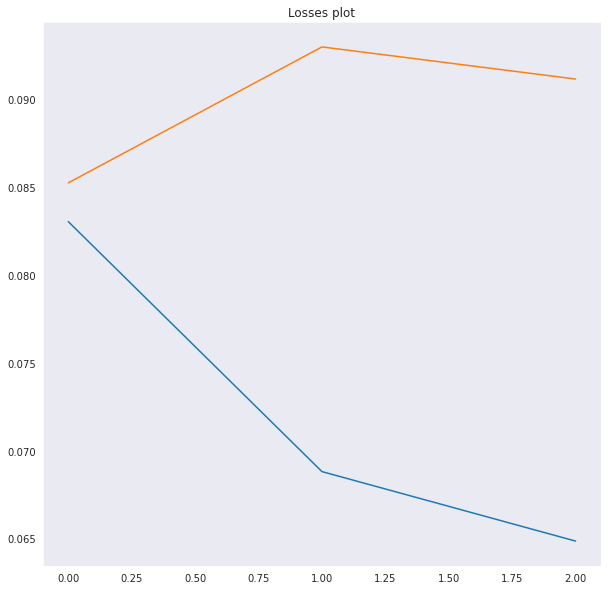

In [28]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
_=plt.title('Losses plot')

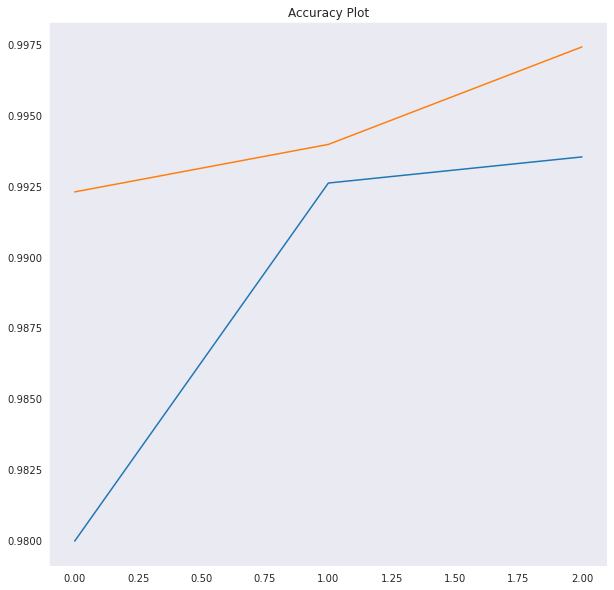

In [29]:
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
_=plt.title('Accuracy Plot')

In [30]:
predictions = model.predict(data)

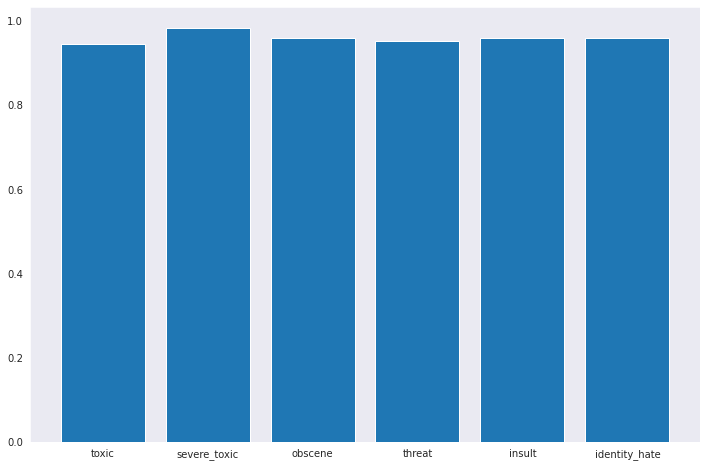

In [31]:
roc_auc = []
for i in range(len(labels)):
    score = roc_auc_score(targets[:,i],predictions[:,i])
    roc_auc.append(score)

plt.figure(figsize=(12,8))
plt.bar(x=range(len(labels)),height=roc_auc)
_=plt.xticks(ticks=range(len(labels)),labels=labels)